In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import Sequential, GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils

from collections import Counter

In [3]:
# constants
DATASET_NAME = "Reddit_Binary"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 2

TRAIN_TEST_SPLIT = 0.8

NUM_HIDDEN_UNITS = 40
EPOCHS = 1000
LR = 0.001

BATCH_SIZE = 16

NUM_NODES_VIEW = 5
NUM_EXPANSIONS = 2

LAYER_NUM = 3
LAYER_KEY = "conv3"

visualisation_utils.set_rc_params()

In [4]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
                
        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, 10)
        
        self.pool = model_utils.Pool()

        # linear layers
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(10, 1, n_classes=num_classes))

    def forward(self, x, edge_index, batch):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
        x = x.squeeze()
    
        self.gnn_node_embedding = x
        
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        self.gnn_node_concepts = x
        
        x = self.pool(x, batch)
        self.gnn_graph_concepts = x
        
        x = self.lens(x)
                
        return self.gnn_node_concepts, x.squeeze(-1)

In [5]:
def run_experiment(seed, path):
    config = {'seed': seed,
                       'dataset_name': DATASET_NAME,
                       'model_name': MODEL_NAME,
                       'num_classes': NUM_CLASSES,
                       'train_test_split': TRAIN_TEST_SPLIT,
                       'batch_size': BATCH_SIZE,
                       'num_hidden_units': NUM_HIDDEN_UNITS,
                       'epochs': EPOCHS,
                       'lr': LR,
                       'num_nodes_view': NUM_NODES_VIEW,
                       'num_expansions': NUM_EXPANSIONS,
                       'layer_num': LAYER_NUM,
                       'layer_key': LAYER_KEY
                      }
    persistence_utils.persist_experiment(config, path, 'config.z')
    
    # load data
    graphs = data_utils.load_real_data(DATASET_NAME)
    train_loader, test_loader, full_train_loader, full_test_loader, full_loader, small_loader = data_utils.prepare_real_data(graphs, TRAIN_TEST_SPLIT, BATCH_SIZE, DATASET_NAME)

    # model training
    model = GCN(graphs.num_node_features, NUM_HIDDEN_UNITS, graphs.num_classes)
    
    # register hooks to track activation
    model = model_utils.register_hooks(model)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train_graph_class(model, train_loader, test_loader, full_loader, EPOCHS, LR, if_interpretable_model=True)
    persistence_utils.persist_model(model, path, 'model.z')

    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    # get model activations for complete dataset
    train_data = next(iter(full_train_loader))
    train_node_concepts, _ = model(train_data.x, train_data.edge_index, train_data.batch)
    train_node_activation = model.gnn_node_embedding
    train_graph_concepts = model.gnn_graph_concepts
    train_graph_activation = model.gnn_graph_concepts
    
    test_data = next(iter(full_test_loader))
    test_node_concepts, _ = model(test_data.x, test_data.edge_index, test_data.batch)
    test_node_activation = model.gnn_node_embedding
    test_graph_concepts = model.gnn_graph_concepts
    test_graph_activation = model.gnn_graph_concepts
    
    node_concepts = torch.vstack((train_node_concepts, test_node_concepts))
    node_activation = torch.vstack((train_node_activation, test_node_activation)).detach().numpy()
    graph_concepts = torch.vstack([train_graph_concepts, test_graph_concepts])
    graph_activation = torch.vstack((train_graph_activation, test_graph_activation)).detach().numpy()

    y = torch.cat((train_data.y, test_data.y))
    expanded_train_y = data_utils.reshape_graph_to_node_data(train_data.y, train_data.batch)
    expanded_test_y = data_utils.reshape_graph_to_node_data(test_data.y, test_data.batch)
    expanded_y = torch.cat((expanded_train_y, expanded_test_y))
    
    train_mask = np.zeros(y.shape[0], dtype=bool)
    train_mask[:train_data.y.shape[0]] = True
    test_mask = ~train_mask
    
    offset = train_data.batch[-1] + 1
    batch = torch.cat((train_data.batch, test_data.batch + offset))
    
    persistence_utils.persist_experiment(node_concepts, path, 'node_concepts.z')
    persistence_utils.persist_experiment(node_activation, path, 'node_activation.z')
    persistence_utils.persist_experiment(node_concepts, path, 'graph_concepts.z')
    persistence_utils.persist_experiment(node_activation, path, 'graph_activation.z')
        
    # generate explanations using LENS
    explanations = lens_utils.explain_classes(model, graph_concepts, y, train_mask, test_mask)
    persistence_utils.persist_experiment(explanations, path, 'explanations.z')
    
    print("\n_____________THIS IS FOR NODES_____________")
    # find centroids
    centroids, centroid_labels, used_centroid_labels = clustering_utils.find_centroids(node_activation, node_concepts, expanded_y)
    persistence_utils.persist_experiment(centroids, path, 'node_centroids.z')
    persistence_utils.persist_experiment(centroid_labels, path, 'node_centroid_labels.z')
    persistence_utils.persist_experiment(used_centroid_labels, path, 'node_used_centroid_labels.z')
    print(f"Number of node cenroids: {len(centroids)}")

    # calculate cluster sizing
    cluster_counts = visualisation_utils.print_cluster_counts(used_centroid_labels)

    # concept alignment
    homogeneity = homogeneity_score(expanded_y, used_centroid_labels)
    
    # clustering efficency
    completeness = completeness_score(expanded_y, used_centroid_labels)
    
    print(f"Concept homogeneity score: {homogeneity}")
    print(f"Concept completeness score: {completeness}")
    concept_metrics = [('homogeneity', homogeneity), ('completeness', completeness), ('cluster_count', cluster_counts)]
    persistence_utils.persist_experiment(concept_metrics, path, 'node_concept_metrics.z')
    
    # plot concept heatmaps
    visualisation_utils.plot_concept_heatmap(centroids, node_concepts, expanded_y, used_centroid_labels, MODEL_NAME, LAYER_NUM, path, id_title="Node ", id_path="node_")
    
    # plot clustering - REDUCING DATA TO TRAINING SET
    test_node_activation = test_node_activation.detach().numpy()
    expanded_test_mask = data_utils.reshape_graph_to_node_data(test_mask, batch)
    node_labels = []
    for x, batch_idx in zip(test_data.x, test_data.batch):
        node_labels.append(np.argmax(x.detach().numpy(), axis=0))
    
    _, centroid_labels, _ = clustering_utils.find_centroids(test_node_activation, node_concepts[expanded_test_mask], expanded_y[expanded_test_mask])
    print("Nodes to visualise ", expanded_test_mask.shape)

    visualisation_utils.plot_clustering(seed, test_node_activation, expanded_test_y, centroids, centroid_labels, used_centroid_labels[expanded_test_mask], MODEL_NAME, LAYER_NUM, path, id_title="Node ", id_path="_node")

    # plot samples
    edges_t = test_data.edge_index.transpose(0, 1).detach().numpy()
    sample_graphs, sample_feat = visualisation_utils.plot_samples(None, test_node_activation, expanded_test_y, LAYER_NUM, len(centroids), "Differential Clustering", "Raw", NUM_NODES_VIEW, edges_t, NUM_EXPANSIONS, path, concepts=centroids)
    persistence_utils.persist_experiment(sample_graphs, path, 'node_sample_graphs.z')
    persistence_utils.persist_experiment(sample_feat, path, 'node_sample_feat.z')
    
    
    print("\n_____________THIS IS FOR GRAPHS____________")
    
    # find centroids
    centroids, centroid_labels, used_centroid_labels = clustering_utils.find_centroids(graph_activation, graph_concepts, y)
    print(f"Number of graph cenroids: {len(centroids)}")
    persistence_utils.persist_experiment(centroids, path, 'graph_centroids.z')
    persistence_utils.persist_experiment(centroid_labels, path, 'graph_centroid_labels.z')
    persistence_utils.persist_experiment(used_centroid_labels, path, 'graph_used_centroid_labels.z')
   
    # calculate cluster sizing
    cluster_counts = visualisation_utils.print_cluster_counts(used_centroid_labels)

    # concept alignment
    homogeneity = homogeneity_score(y, used_centroid_labels)
    
    # clustering efficency
    completeness = completeness_score(y, used_centroid_labels)
    
    print(f"Concept homogeneity score: {homogeneity}")
    print(f"Concept completeness score: {completeness}")
    concept_metrics = [('homogeneity', homogeneity), ('completeness', completeness), ('cluster_count', cluster_counts)]
    persistence_utils.persist_experiment(concept_metrics, path, 'graph_concept_metrics.z')  
    
    # plot concept heatmaps
    visualisation_utils.plot_concept_heatmap(centroids, graph_concepts, y, used_centroid_labels, MODEL_NAME, LAYER_NUM, path, id_title="Graph ", id_path="graph_")
    
    # plot clustering
    visualisation_utils.plot_clustering(seed, graph_activation, y, centroids, centroid_labels, used_centroid_labels, MODEL_NAME, LAYER_NUM, path, id_title="Graph ", id_path="_graph")

    # clean up
    plt.close()

Global seed set to 92



START EXPERIMENT-----------------------------------------


Dataset: REDDIT-BINARY(2000):
Number of graphs: 2000
Number of features: 1
Number of classes: 2

Class split - Training 0: 798 1:802, Test 0: 202 1: 198


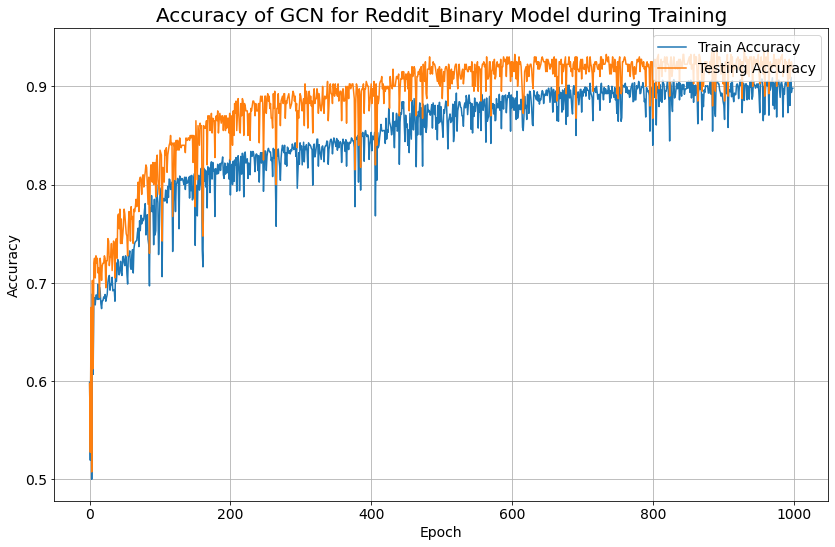

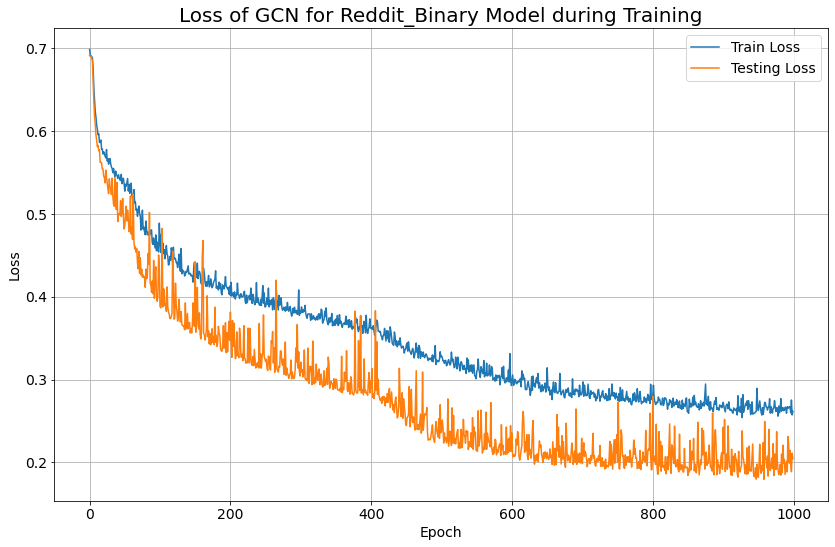

Explanation class 0: ~feature0000000000 - acc. = 0.5807 - compl. = 1.0000
Explanation class 1: feature0000000000 - acc. = 0.5807 - compl. = 1.0000

_____________THIS IS FOR NODES_____________
Number of node cenroids: 47
Cluster sizes by cluster id:
	Cluster 0: 19613
	Cluster 1: 2
	Cluster 2: 103
	Cluster 3: 5
	Cluster 4: 1
	Cluster 5: 14
	Cluster 6: 1
	Cluster 7: 1
	Cluster 8: 67
	Cluster 9: 4
	Cluster 10: 3
	Cluster 11: 2
	Cluster 12: 60
	Cluster 13: 1
	Cluster 14: 12
	Cluster 15: 2
	Cluster 16: 2
	Cluster 17: 1021
	Cluster 18: 2
	Cluster 19: 4534
	Cluster 20: 38182
	Cluster 21: 10057
	Cluster 22: 1
	Cluster 23: 1
	Cluster 24: 2
	Cluster 25: 1
	Cluster 26: 1
	Cluster 27: 1
	Cluster 28: 1
	Cluster 29: 1
	Cluster 30: 1
	Cluster 31: 1
	Cluster 32: 6
	Cluster 33: 1
	Cluster 34: 3
	Cluster 35: 4
	Cluster 36: 1
	Cluster 37: 2
	Cluster 38: 1
	Cluster 39: 2
	Cluster 40: 7
	Cluster 41: 7
	Cluster 42: 1
	Cluster 43: 1
	Cluster 44: 449
	Cluster 45: 4
	Cluster 46: 1523
Concept homogeneity score: 

/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.draw()
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/src/visualisation_utils.py:87: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, f"{id_path}concept_heatmap_layer{layer_num}.png"))


Nodes to visualise  torch.Size([75712])


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


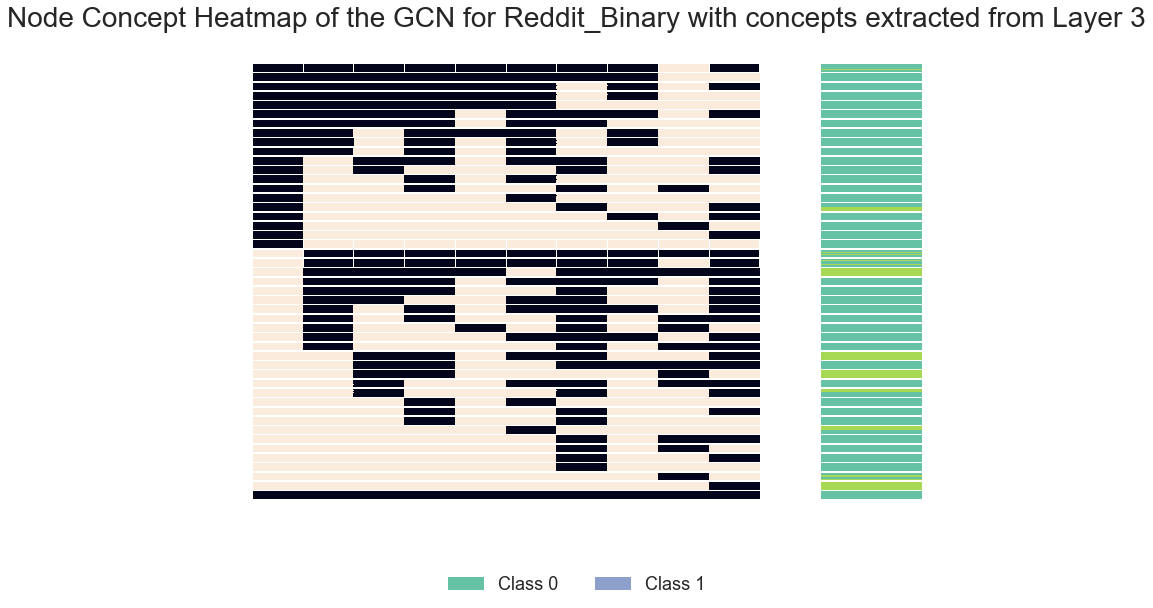

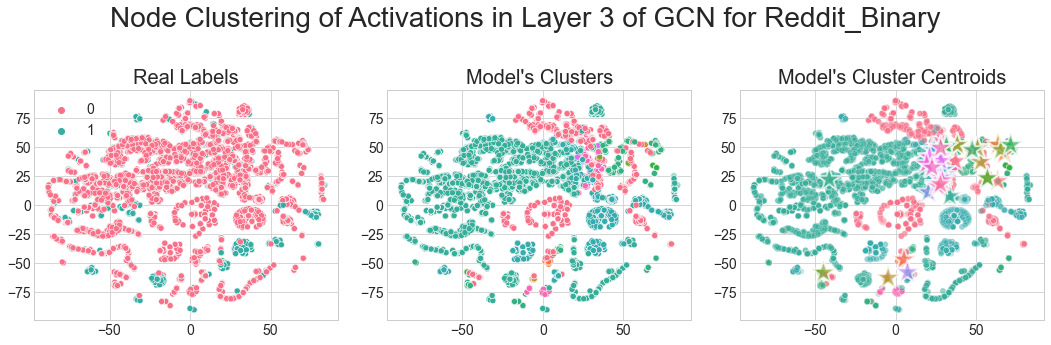

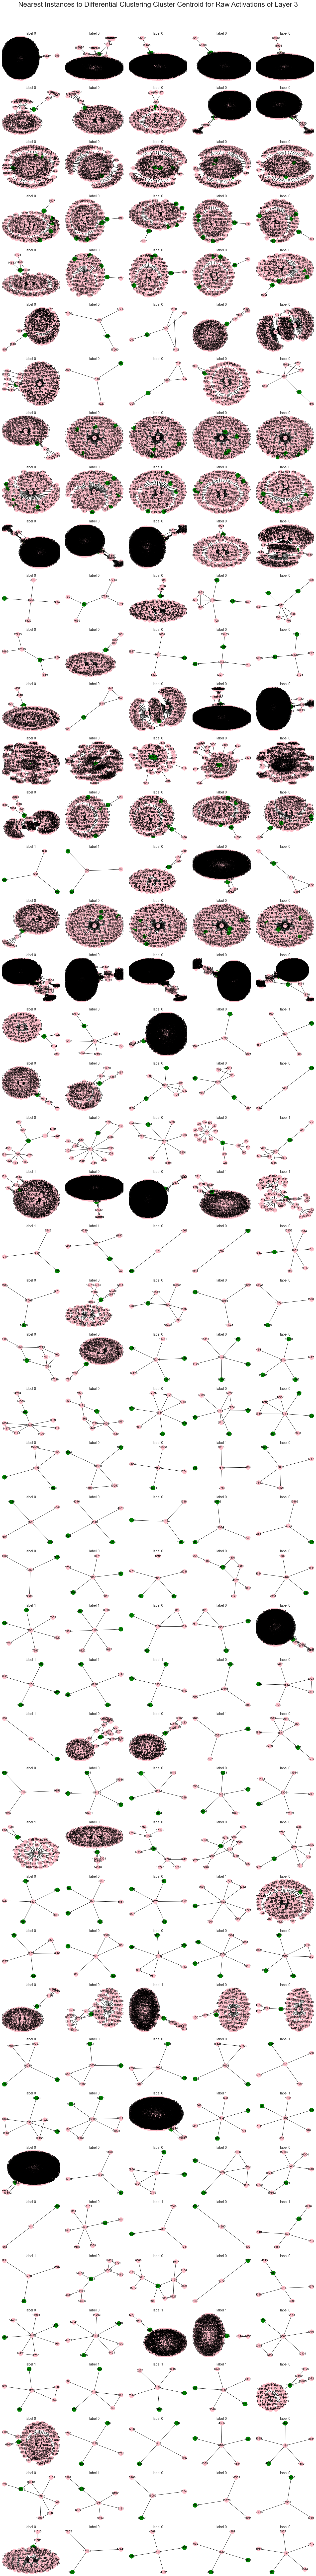


_____________THIS IS FOR GRAPHS____________
Number of graph cenroids: 6
Cluster sizes by cluster id:
	Cluster 0: 19
	Cluster 1: 1
	Cluster 2: 2
	Cluster 3: 6
	Cluster 4: 138
	Cluster 5: 34
Concept homogeneity score: 0.26892145724174243
Concept completeness score: 0.1944333695275035


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

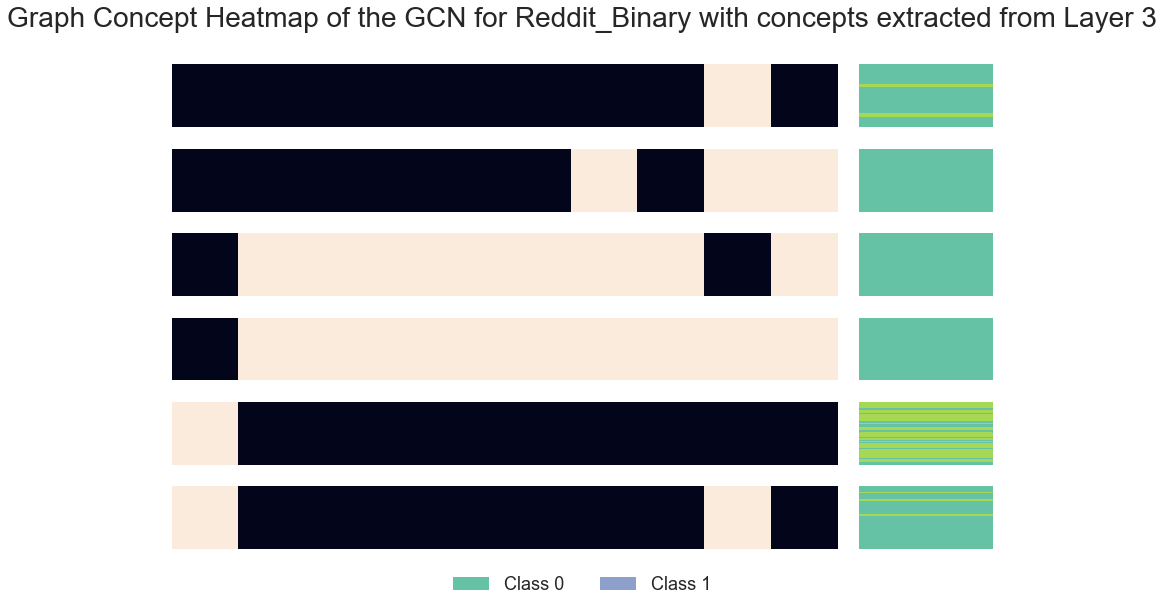

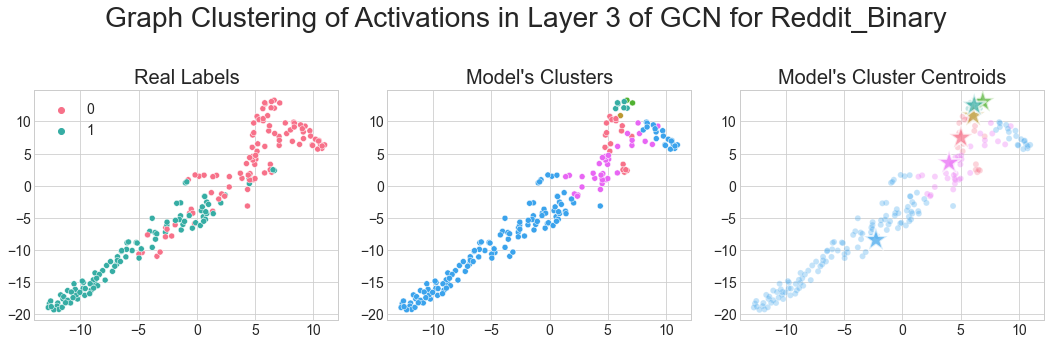


END EXPERIMENT-------------------------------------------



In [6]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
random_seeds = [92]

for seed in random_seeds:
    print("\nSTART EXPERIMENT-----------------------------------------\n")
    seed_everything(seed)
    
    path = os.path.join("..", "output", DATASET_NAME, f"seed_{seed}")
    data_utils.create_path(path)

    run_experiment(seed, path)
    
    print("\nEND EXPERIMENT-------------------------------------------\n")